## Generate music with Variational AutoEncoder
![iame_intro](https://i.ytimg.com/vi/WI1xExDWVF0/maxresdefault.jpg)

## Introduction
This work is inspired by the research paper [Jukebox: A Generative Model for Music](https://cdn.openai.com/papers/jukebox.pdf). In this notebook, I have developed a generative model that could generate music from a variational autoencoder trained with a category of music. I have selected the jazz and classical music categories. The entire model is implemented in TensorFlow and used Librosa for audio processing. The input sampling rate is 3000 for processing the audio file into a readable array.

## What is Variational AutoEncoder?
 VAE is an autoencoder whose encodings distribution is regularised during the training in order to ensure that its latent space has good properties allowing us to generate some new data. A variational autoencoder (VAE) provides a probabilistic manner for describing an observation in latent space.
![VAE](https://miro.medium.com/max/3080/1*82EghOQR2Z5uuwUjFiVV2A.png) 

Source -  [The Intuition Behind Variational Autoencoders](https://medium.com/@realityenginesai/understanding-variational-autoencoders-and-their-applications-81a4f99efc0d), [Variational autoencoders.](https://www.jeremyjordan.me/variational-autoencoders/)

In [ ]:
#!/opt/conda/bin/python3.7 -m pip install --upgrade pip
#!pip install tensorflow-addons
#!pip install --upgrade --ignore-installed tensorflow
#!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [5]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

2022-05-19 13:10:00.021752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 13:10:00.021769: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [57]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [1]:
train_size = 60000
BATCH_SIZE = 10
test_size = 10000
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 10

BASE_PATH = 'Data/genres_original'

## Data preprocessing

In [2]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[[0,52,19,39,71,12,75,85,3,45,24,46,88]]) #99,10,66,76,41
    train_music_2 = list(music_list[[4,43,56,55,45,31,11,13,70,37,21,78]]) #65,32,53,22,19,80,89,
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

In [3]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    data_ = data_.reshape(1,90001)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [6]:
TrackSet_1, TrackSet_2 = DatasetLoader('jazz')

## sample original music

In [7]:
sample = TrackSet_1[1]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=30)
ipd.Audio(sample_,rate=3000)

AttributeError: module 'librosa.display' has no attribute 'waveplot'

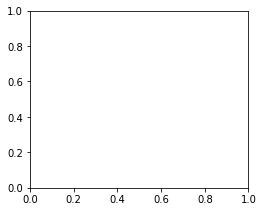

In [9]:
import librosa.display as d
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    d.waveplot(j[0], sr=3000)
    

In [10]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


2022-05-19 13:11:27.300571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-19 13:11:27.300601: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-19 13:11:27.300620: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (chia): /proc/driver/nvidia/version does not exist
2022-05-19 13:11:27.300898: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Explaining the concept

## Encoder network
This defines the approximate posterior distribution *q(z|x)*, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation *z*. In this example, we simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. We output log-variance instead of the variance directly for numerical stability.
## Decoder network
This defines the conditional distribution of the observation *p(x|z)*, which takes a latent sample *z* as input and outputs the parameters for a conditional distribution of the observation. We model the latent distribution prior *p(z)* as a unit Gaussian.
## Reparameterization
To generate a sample *z* for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation *x*. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick. In our example, we approximate *z* using the decoder parameters and another parameter *ϵ* as follows:

z = μ + σ.ϵ

Source: [Tensorflow](https://www.tensorflow.org/tutorials/generative/cvae)

## Network architecture

In [37]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters, name, type='encode'):
        super(Resnet1DBlock, self).__init__(name=name)
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)


In [33]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,90001), name='input'),
                layers.Conv1D(64,1,2, name='conv1'),
                Resnet1DBlock(64,1, name='encode1'),
                layers.Conv1D(128,1,2, name='conv2'),
                Resnet1DBlock(128,1, name='encode2'),
                layers.Conv1D(128,1,2, name='conv3'),
                Resnet1DBlock(128,1, name='encode3'),
                layers.Conv1D(256,1,2, name='conv4'),
                Resnet1DBlock(256,1, name='encode4'),
                # No activation
                layers.Flatten(name='flat'),
                layers.Dense(latent_dim+latent_dim, name='dense')

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,), name='input'),
                layers.Reshape(target_shape=(1,latent_dim), name='reshape'),
                Resnet1DBlock(512,1, name='decode1'),
                layers.Conv1DTranspose(512,1,1, name='conv1'),
                Resnet1DBlock(256,1, name='decode2'),
                layers.Conv1DTranspose(256,1,1, name='conv2'),
                Resnet1DBlock(128,1, name='decode3'),
                layers.Conv1DTranspose(128,1,1, name='conv3'),
                Resnet1DBlock(64,1, name='decode4'),
                layers.Conv1DTranspose(64,1,1, name='conv4'),
                # No activation
                layers.Conv1DTranspose(90001,1,1, name='conv5'),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [20]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [21]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [22]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

## Loss Optimization
Here we have optimized two lossess, the **KL loss** and **reconstruction loss**.<br>

## KL Loss

The KL divergence tells us how well the probability distribution Q approximates the probability distribution P by calculating the cross-entropy minus the entropy. Intuitively, you can think of that as the statistical measure of how one distribution differs from another.
In VAE, let X be the data we want to model, z be latent variable, P(X) be the probability distribution of data, P(z) be the probability distribution of the latent variable and P(X|z) be the distribution of generating data given latent variable.

In the case of variational autoencoders, our objective is to infer P(z)
from P(z|X). P(z|X) is the probability distribution that projects our data into latent space. But since we do not have the distribution P(z|X), we estimate it using its simpler estimation Q.

Now while training our VAE, the encoder should try to learn the simpler distribution Q(z|X)
such that it is as close as possible to the actual distribution P(z|X). This is where we use KL divergence as a measure of a difference between two probability distributions. The VAE objective function thus includes this KL divergence term that needs to be minimized.

*DKL[Q(z|X)||P(z|X)] = E[ logQ(z|X) − logP(z|X) ]*

## Reconstruction loss
As the name suggest, it measures the reconstruction of original input x. This network can be trained by minimizing the reconstruction error, which measures the differences between our original input and the consequent reconstruction.

In [23]:
@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [38]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [39]:
import librosa.display

def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        librosa.display.waveshow(wave[0], sr=3000)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()

In [40]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

## Training the model

AttributeError: module 'librosa.display' has no attribute 'waveplot'

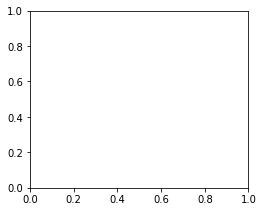

In [69]:
generate_and_save_images(model, 0, test_sample, 'jazz')
def train(train_dataset, test_dataset, model, save):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, 
                                                                                       elbo, 
                                                                                       end_time - start_time
                                                                                      ))
        generate_and_save_images(model,
                                 epoch, 
                                 test_sample,
                                 save)
train(train_dataset, test_dataset, model, 'jazz')

In [47]:
anim_file_1 = 'jazz_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('jazz*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

NameError: name 'filename' is not defined

## Visualization

In [48]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)

ModuleNotFoundError: No module named 'tensorflow_docs'

## Generated Music - Jazz
Let us listen to the music generated by our model, trained only with jazz music.

In [49]:
def inference(test_dataset, model):  
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

saved_musics = inference(test_dataset, model)

In [50]:
music1=saved_musics[0][0]
ipd.Audio(music1,rate=3000)

In [51]:
music2=saved_musics[9][0]
ipd.Audio(music2,rate=3000)

In [52]:
music3=saved_musics[5][0]
ipd.Audio(music3,rate=3000)

In [53]:
music4=saved_musics[10][0]
ipd.Audio(music4,rate=3000)

In [54]:
music5=saved_musics[8][0]
ipd.Audio(music5,rate=3000)

In [55]:
music6=saved_musics[7][0]
ipd.Audio(music6,rate=3000)

## Example
Let's try out another example with classical music. The code shown below is the same as above, its just the same experiment over a different music category.

In [58]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [59]:
TrackSet_3, TrackSet_4 = DatasetLoader('classical')

In [60]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_3))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_4))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

In [61]:
model = CVAE(latent_dim)

In [62]:
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

In [63]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)
@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [64]:
#generate_and_save_images(model, 0, test_sample, 'classical')   
train(train_dataset, test_dataset, model, 'classical')

Epoch: 20, Test set ELBO: -14219.685546875, time elapse for current epoch: 0.7671821117401123


In [65]:
anim_file_2 = 'classical_cvae.gif'

with imageio.get_writer(anim_file_2, mode='I') as writer:
    filenames = glob.glob('classical*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

NameError: name 'filename' is not defined

In [66]:
embed.embed_file(anim_file_2)

NameError: name 'embed' is not defined

## Generated music - Classical

In [67]:
save_music_classic = inference(test_dataset, model)

In [68]:
music1=save_music_classic[1][0]
ipd.Audio(music1,rate=3000)

In [ ]:
music2=save_music_classic[9][0]
ipd.Audio(music2,rate=3000)

In [ ]:
music3=save_music_classic[4][0]
ipd.Audio(music3,rate=3000)

In [ ]:
music4=save_music_classic[5][0]
ipd.Audio(music4,rate=3000)

In [ ]:
music5=save_music_classic[8][0]
ipd.Audio(music5,rate=3000)

In [ ]:
music6=save_music_classic[7][0]
ipd.Audio(music6,rate=3000)

## Conclusion
**WoW! the generated music sounds really good....**
![conc](https://i.ytimg.com/vi/PdzFMIDzp2I/maxresdefault.jpg)
<br>
First of all, I got to learn a lot while working on this project. There are a lot of aspects discussed in the research paper [Jukebox: A Generative Model for Music](https://cdn.openai.com/papers/jukebox.pdf), which could be implemented for better performance and promising result. One of the aspects is the optimization of **Spectral loss**. I have implemented the model which works only for music generation, for generating a lyrical song this model won't generate a promising result. For generating lyrical songs birectional lstm, transformer networks and attention layers would be a better choice according to me for contructing the network architecture. Also, I have trained my model against a particular category of music, this solution could also be made more interesting by training the model against two or more categories of music.

## Thank you.
![thank you](https://www.scienceabc.com/wp-content/uploads/2016/06/orkestra-Music-conductor.jpg)

### Please <span style="color:red">Up-Vote</span> and <span style="color:red">Share</span> this notebook if you like it or find the content informative. Also, let me know your opinions and suggestions in the comment section below.